# Keywords (W+J)
## En este notebook se definen 6 funciones:
### (1) graph_weighted(text,K,filter_nouns_adj,digraph) que recibe un texto en forma de string (text), el tamano de la ventana de co-ocurrencia en forma de entero (K), la decision si filtrar NOUNs y ADJs en forma de BOOL (filter_nouns_adj) y la decision de usar grafo dirigido en forma de BOOL (digraph). Esta funcion entrega el grafo de ocurrencia asociado a un texto. 
### (2) keywords_pagerank(text,number_keywords,filter_nouns_adj,K,digraph) que recibe ademas de las mismas variables que (1) el numero de keywords (number_keywords). Esta funcion entrega un conjunto de keywords asociado a un texto. 
### (3) keywords_kcore(text,filter_nouns_adj,K,digraph) que recibe las mismas variables que (1) y entrega los nodos de main core del grafo como una manera de representar los keywords. 
### (4) bigram_keywords(text,filter_nouns_adj,K,digraph) que recibe idem que (1) y entrega un conjunto de 2-gramas de keywords ordenados segun frecuencia de aparicion en el texto (mayor a menor). 
### (5) visualization_maincore(text,K,filter_nouns_adj,digraph), que recibe las mismas variables que (3) y visualiza el grafo luego de que podamos aristas con un maximum spanning tree.
### (6) keywords_kcore_rank(text,filter_nouns_adj,K,digraph), que recibe idem que (3) y organiza las keywords del main core mediante CoreRank, es decir, segun la suma de los core number de sus vecinos en el grafo.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import spacy
import operator
nlp = spacy.load('en')
from nltk.corpus import stopwords
from nltk import sent_tokenize
import re
import string
stop_words = set(stopwords.words('english'))

## (0) funcion que limpia los textos

In [2]:
def clean(text,filter_nouns_adj):
    text=re.sub("[\(\[].*?[\)\]]", "", text)
    sentences=sent_tokenize(text)
    sentences=[nlp(sentence) for sentence in sentences]
    if filter_nouns_adj==True:
        sentences=[[token.lemma_ for token in sentence if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ' or token.pos_=='PROPN'] for sentence in sentences]
    else:
        sentences=[[token.lemma_ for token in sentence] for sentence in sentences]

    text=[item for sublist in sentences for item in sublist]
    text=[word for word in text if not word in stop_words]
    table=str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text] ## removemos los simbolos que funcionan como sustantivos, p.e., %
    text = list(filter(lambda a: a != '', text))
    return text


## ejemplo

In [3]:
text='Sequencing the Neanderthal genome (Green et al., 2010, Prüfer et al., 2014), the Denisovan genome (Reich et al., 2010), and several early modern human genomes from Eurasia (Fu et al., 2014, Fu et al., 2015) has confirmed that archaic hominins left their mark in the genomes of modern humans (Plagnol and Wall, 2006, Sankararaman et al., 2014, Vernot and Akey, 2014, Vernot et al., 2016). Present-day individuals in Eurasia inherited ∼2% of their genome from Neanderthals (Green et al., 2010), and individuals from Oceania inherited ∼5% of their genome from Denisovans (Reich et al., 2010). Suggestive evidence indicates that admixture from other unidentified hominin species occurred in Africa (Hammer et al., 2011, Hsieh et al., 2016, Lachance et al., 2012, Plagnol and Wall, 2006, Wall et al., 2009). To understand the functional, phenotypic, and evolutionary consequences of archaic admixture, it is necessary to identify the specific haplotypes and alleles that were inherited from archaic hominin ancestors (Huerta-Sánchez et al., 2014, Juric et al., 2016, Sankararaman et al., 2014, Simonti et al., 2016, Vernot and Akey, 2014). Approaches to identifying introgressed haplotypes include methods that specifically incorporate reference archaic hominin genome sequences and reference-free methods that do not utilize such information. An example of the former category is the method of Sankararaman et al. (2014), which identifies archaic haplotypes by comparing modern human haplotypes to a reference archaic sequence. The latter category of methods include the S∗ statistic (Plagnol and Wall, 2006), which searches for the mutational signature that ancient admixture leaves in the genomes of present-day humans. The S∗ approach is powerful for finding introgressed haplotypes in the absence of an archaic reference genome because it leverages the unusual mutational characteristics of introgressed haplotypes. Because of the long divergence time between Neanderthals and modern humans, Neanderthals carry many alleles that are specific to their lineage. Such alleles are present on introgressed haplotypes but are absent or rare in African genomes. Further, based on the recent timing of admixture, introgressed haplotypes are expected to be maintained without recombination over distances of approximately 50 kb on average (Sankararaman et al., 2012), resulting in high levels of linkage disequilibrium (LD) between Neanderthal-specific alleles in non-African human genomes. In this study, we develop an S∗-like method that has increased power and is suitable for large-scale genome-wide data. We apply the method to large sets of sequenced data from Eurasia and Oceania and identify putative archaic-specific alleles. We examine the rate at which these alleles match the sequenced archaic genomes and the role of the genes containing these alleles, to obtain insights into the history of the admixture events and their impact on modern human genomes.'
clean(text,True)

['neanderthal',
 'genome',
 'denisovan',
 'genome',
 'several',
 'early',
 'modern',
 'human',
 'genome',
 'eurasia',
 'archaic',
 'hominin',
 'mark',
 'genome',
 'modern',
 'human',
 'present',
 'day',
 'individual',
 'eurasia',
 '∼2',
 'genome',
 'neanderthals',
 'individual',
 'oceania',
 'genome',
 'denisovans',
 'suggestive',
 'evidence',
 'unidentified',
 'hominin',
 'specie',
 'africa',
 'functional',
 'phenotypic',
 'evolutionary',
 'consequence',
 'archaic',
 'admixture',
 'necessary',
 'specific',
 'haplotype',
 'allele',
 'archaic',
 'hominin',
 'ancestor',
 'approach',
 'introgressed',
 'haplotype',
 'method',
 'reference',
 'archaic',
 'hominin',
 'genome',
 'sequence',
 'reference',
 'free',
 'method',
 'information',
 'example',
 'former',
 'category',
 'method',
 'sankararaman',
 'et',
 'al',
 'haplotype',
 'modern',
 'human',
 'haplotype',
 'reference',
 'archaic',
 'sequence',
 'latter',
 'category',
 'method',
 's∗',
 'statistic',
 'mutational',
 'signature',
 'ancie

## (1) grafo de palabras

In [4]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
# digraph indica el tipo de grafo- True = dirigido, False = no dirigido
def graph_weighted(text,K,filter_nouns_adj,digraph):
    text=clean(text,filter_nouns_adj)
    unique_words=list(set(text))
    if digraph==True: ## grafo dirigido o no dirigido
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    for word in unique_words:
        G.add_node(word)
    for word in unique_words: ## recorremos el texto y encontramos los indices de todas las aparicions de word (index_word)
        index_word=[index for index, value in enumerate(text) if value == word]
        ## ahora buscamos las palabras vecinas en una ventana de largo K (hacia adelante)
        for index in index_word:
            for k in range(1,K+1):
                if index+k in range(len(text)):
                    if G.has_edge(text[index],text[index+k])==False:
                        G.add_edge(text[index],text[index+k],weight=1)
                    else:
                        x=G[text[index]][text[index+k]]['weight']
                        G[text[index]][text[index+k]]['weight']=x+1
    
    return G

In [5]:
graph_weighted(text,4,True,True)

## (2) keywords segun pagerank

In [6]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
# number_keywords indica el numero de keywords
# digraph indica si queremos un grafo dirigido (True) o no dirigido (False)
def keywords_pagerank(text,number_keywords,filter_nouns_adj,K,digraph):
    n=len(clean(text,filter_nouns_adj))
    G=graph_weighted(text,K,filter_nouns_adj,digraph)
    keywords=nx.pagerank(G, alpha=0.85, weight='weight')
    if n<number_keywords: ## en el caso de que el texto sea muy corto (incluso menor al numero de keywords)
        number_keywords=n
    return list(list(zip(*sorted(keywords.items(), key=operator.itemgetter(1),reverse=True)))[0][:number_keywords])

In [7]:
keywords_pagerank(text,10,True,4,True)

['genome',
 'archaic',
 'haplotype',
 'allele',
 'human',
 'method',
 'modern',
 'introgressed',
 'admixture',
 'specific']

## (3) keywords segun main core

In [19]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
# digraph es el tipo de grafo - True = grafo dirigido, False = grafo no dirigido
# en esta funcion, no es necesario indicar el numero de keywords. Fijamos un maximo de 10 (esto puede ser un parametro)
def keywords_kcore(text,filter_nouns_adj,K,digraph):
    G=graph_weighted(text,K,filter_nouns_adj,digraph)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos para evitar que Networkx entregue un error
    main_core_nodes=list(nx.k_core(G).nodes())
    n=len(main_core_nodes)
    if n>10:
        return main_core_nodes[:10]
    else:
        return main_core_nodes

In [20]:
keywords_kcore(text,True,4,True)


['method',
 'modern',
 'haplotype',
 'neanderthals',
 'allele',
 'specific',
 'present',
 'day',
 'introgressed',
 'eurasia']

## (4) 2-gramas de keywords

In [10]:
def bigram_keywords(text,filter_nouns_adj,K,digraph):
    bigram=[]
    G=graph_weighted(text,K,filter_nouns_adj,digraph)
    G.remove_edges_from(nx.selfloop_edges(G))
    main_core=nx.k_core(G) ## subgrafo del grafo de co-ocurrencia
    list_edges=main_core.edges(data=True) ## lista de posibles bigramas, las aristas del main_core
    destruct_edges=list(zip(*list_edges))
    x=destruct_edges[0]
    y=destruct_edges[1]
    w=destruct_edges[2]
    text=clean(text,True) ## lista de palabras (que dependen de True o False para ver que clase incluyen)
    
    for i in range(len(x)):
        key_1=x[i]
        key_2=y[i]
        exists = (key_1,key_2) in zip(text, text[1:]) ## miramos si la arista aparece en el texto como palabras adyacentes
        if exists==True:
            bigram+=[(key_1+' '+key_2,w[i]['weight'])]
    BIGRAM=list(zip(*sorted(bigram, key=lambda tup: tup[1],reverse=True)))[0] ## ordenamos segun frecuencia del bigrama
    n=len(BIGRAM)
    if n>10: ## tambien fijamos en 10 el numero maximo de bigramas (puede ser un parametro)
        return list(BIGRAM[:10])
    else:
        return list(BIGRAM)
    
    

In [11]:
bigram_keywords(text,True,4,True)

['modern human',
 'specific allele',
 'introgressed haplotype',
 'haplotype reference',
 'archaic genome',
 'allele archaic',
 'archaic hominin',
 'human genome',
 'allele present',
 'present day']

## Ahora agregamos una quinta funcion que permite visualizar el main core del grafo de co-ocurrencia

## (5) visualizacion de main core

In [12]:
def visualization_maincore(text,K,filter_nouns_adj,digraph):
    G=graph_weighted(text,K,filter_nouns_adj,digraph)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos para evitar que Networkx entregue un error
    G=nx.k_core(G)
    G=G.to_undirected()
    G=nx.maximum_spanning_tree(G, weight='weight') ## podamos el grafo utilizando maximum spanning tree
    pos = nx.spring_layout(G)
    labels={i:i for i in G.nodes}
    nx.draw_networkx_nodes(G, pos, G.nodes, node_size = 15,node_color='r')
    nx.draw_networkx_edges(G, pos, alpha=0.5,width=0.1,edge_color='k')
    nx.draw_networkx_labels(G,pos,labels,font_size=10)
    plt.axis('off')
    plt.savefig('main_core.eps', format='eps', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

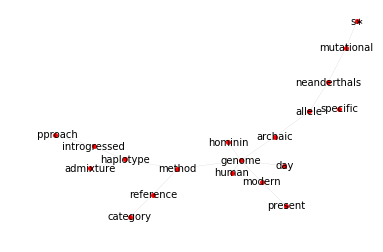

In [13]:
visualization_maincore(text,11,True,True)

## En otra funcion, jerarquizamos las palabras del main core de acuerdo con el CoreRank
### http://www.lix.polytechnique.fr/~anti5662/eacl_17_real_time_meladianos_tixier_nikolentzos_vazirgiannis.pdf

## (6) main core rankeado segun CoreRank

In [14]:
# K es el largo de la ventana
# filter_nouns_adj indica el tipo de filtrado
# digraph es el tipo de grafo - True = grafo dirigido, False = grafo no dirigido
# en esta funcion, no es necesario indicar el numero de keywords. Fijamos un maximo de 10 (esto puede ser un parametro)
def keywords_kcore_rank(text,filter_nouns_adj,K,digraph):
    G=graph_weighted(text,K,filter_nouns_adj,digraph)
    G.remove_edges_from(nx.selfloop_edges(G)) ## borramos ciclos para evitar que Networkx entregue un error
    core_number=nx.core_number(G) ## core number de los nodos de G
    core_rank={word:sum([core_number[w] for w in list(dict(G[word]).keys())]) for word in list(core_number.keys())}
    main_core_nodes=list(nx.k_core(G).nodes())
    ## ahora vemos el core rank de los nodos del main core
    main_core_rank=[]
    for node in main_core_nodes:
        main_core_rank+=[(node,core_rank[node])]
    ## ordenamos segun core rank decreciente
    main_core_rank=sorted(main_core_rank, key=lambda tup: tup[1],reverse=True)
    main_core_rank=list(zip(*main_core_rank))[0]
    ## elegimos 10 keywords
    n=len(main_core_rank)
    if n>10:
        return list(main_core_rank[:10])
    else:
        return list(main_core_rank)
    

In [15]:
keywords_kcore_rank(text,True,4,True)

['genome',
 'haplotype',
 'archaic',
 'human',
 'method',
 'allele',
 'admixture',
 'hominin',
 'modern',
 'introgressed']